# Programs

Esta tabla contiene la información a nivel de programa. Es decir, contiene el porcentaje de clases definidas en el programa, el porcentaje de interfaces y el porcentaje de enumerados. También podemos encontrar otros dos campos que nos indican si el código está en el paquete por defecto o si hay código otros paquetes.  --> ABEL COMPLETAR <--

## 1 - Obtencion de datos

In [73]:
from notebooks_utils import *
import psycopg2
import sqlalchemy

db_connection = sqlalchemy.create_engine(DB_CONNECTION_STR)

sql_query = open(file='./queries/programs.sql', mode='r').read()
full_table = pd.read_sql_query(sql=sql_query, con=db_connection)

# Table name, features and target.
TABLE_NAME = 'programs'
TABLE_FEATURES = ['program__program_id','program__has_sub_dirs_with_code','program__has_packages','program__number_of_modules','program__number_of_sub_dirs_with_code','program__number_of_packages','program__class_defs_pct','program__function_defs_pct','program__enum_defs_pct','program__has_code_root_package','program__average_defs_per_module','program__expertise_level']
TABLE_TARGET = 'program__expertise_level'

# Load features and target.
X, y = full_table[TABLE_FEATURES], full_table[[TABLE_TARGET]].iloc[:,0]

# Print information about the loaded table.
print(f'Features shape: {X.shape}')
print(f'Target shape: {y.shape}')

print(f'As we can see the downloaded data contains a total of {X.shape[0]} instances. Each of the instances corresponds to a program. For each program we have {X.shape[1]} attributes.')

Features shape: (1609, 12)
Target shape: (1609,)
As we can see the downloaded data contains a total of 1609 instances. Each of the instances corresponds to a program. For each program we have 12 attributes.


## 2 - Exploracion de datos

Una vez tenemos nuestra tabla en un dataframe el siguiente paso es explorarla para ver qué tipo de información contiene.

In [74]:
print(X.info())
print('=============')
print(y.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1609 entries, 0 to 1608
Data columns (total 12 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   program__program_id                    1609 non-null   int64  
 1   program__has_sub_dirs_with_code        1609 non-null   bool   
 2   program__has_packages                  1609 non-null   bool   
 3   program__number_of_modules             1609 non-null   int64  
 4   program__number_of_sub_dirs_with_code  1609 non-null   int64  
 5   program__number_of_packages            1609 non-null   int64  
 6   program__class_defs_pct                1609 non-null   float64
 7   program__function_defs_pct             1609 non-null   float64
 8   program__enum_defs_pct                 1609 non-null   float64
 9   program__has_code_root_package         1609 non-null   bool   
 10  program__average_defs_per_module       1609 non-null   float64
 11  prog

Cómo podemos ver la tabla está compuesta por ocho variables numéricas, tres variables boleanas y una de tipo objeto. Esta última variable es la clase con la que se ha etiquetado la instancia. Sin embargo, en algunas ocasiones esta última clase no la vamos a utilizar. Por ejemplo, si queremos obtener clusters por medio de aprendizaje no supervisado.

### 2.1 - Balance de clases

In [75]:
instances_for_class_low = len(full_table[full_table[TABLE_TARGET] == "BEGINNER"])
instances_for_class_high = len(full_table[full_table[TABLE_TARGET] == "EXPERT"])

print(f"The dataset contains {instances_for_class_low/len(full_table)*100:.4}% instances for BEGINNER class and {instances_for_class_high/len(full_table)*100:.4}% for EXPERT class.")

The dataset contains 98.88% instances for BEGINNER class and 1.119% for EXPERT class.


### 2.2 - Duplicados
Miramos si la tabla tiene entradas duplicadas.

In [76]:
number_of_duplicated_entries = sum(full_table.duplicated(subset=TABLE_FEATURES + [TABLE_TARGET]))
duplicated_entries_pct = number_of_duplicated_entries / len(full_table) * 100
print(f"The dataset contains [{duplicated_entries_pct:.4}%] of duplicated entries.")

The dataset contains [0.0%] of duplicated entries.


### 2.3 - Valores Nulos 
Miramos si alguna de las variables que contiene la tabla contiene algún valor que sea nulo.

In [77]:
X.isnull().sum()

program__program_id                      0
program__has_sub_dirs_with_code          0
program__has_packages                    0
program__number_of_modules               0
program__number_of_sub_dirs_with_code    0
program__number_of_packages              0
program__class_defs_pct                  0
program__function_defs_pct               0
program__enum_defs_pct                   0
program__has_code_root_package           0
program__average_defs_per_module         0
program__expertise_level                 0
dtype: int64

Aunque una columna no contenga valores nulos podría ser que contenga valores vacíos. Si los hubiese la siguiente función los mostraría.

In [78]:
print_empty_cols(X)

program__program_id
-------------------
0 instances with no value for the column program__program_id


program__has_sub_dirs_with_code
-------------------------------
0 instances with no value for the column program__has_sub_dirs_with_code


program__has_packages
---------------------
0 instances with no value for the column program__has_packages


program__number_of_modules
--------------------------
0 instances with no value for the column program__number_of_modules


program__number_of_sub_dirs_with_code
-------------------------------------
0 instances with no value for the column program__number_of_sub_dirs_with_code


program__number_of_packages
---------------------------
0 instances with no value for the column program__number_of_packages


program__class_defs_pct
-----------------------
0 instances with no value for the column program__class_defs_pct


program__function_defs_pct
--------------------------
0 instances with no value for the column program__function_defs_pct


pr

### 2.4 - Describimos los valores de las variables de la tabla.

In [79]:
np.transpose(X.describe(percentiles=[.25, .50, .75], include = ['object', 'float', 'bool', 'int']))

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
program__program_id,1609.0,NaN,NaN,NaN,6576383.03729,985646.321859,1.0,6031376.0,6416833.0,6659240.0,9339639.0
program__has_sub_dirs_with_code,1609,2,False,1558,NaN,NaN,NaN,NaN,NaN,NaN,NaN
program__has_packages,1609,2,False,1586,NaN,NaN,NaN,NaN,NaN,NaN,NaN
program__number_of_modules,1609.0,NaN,NaN,NaN,11.327533,125.3427,1.0,1.0,3.0,3.0,3294.0
program__number_of_sub_dirs_with_code,1609.0,NaN,NaN,NaN,0.394034,6.886436,0.0,0.0,0.0,0.0,238.0
program__number_of_packages,1609.0,NaN,NaN,NaN,1.642014,34.308121,0.0,0.0,0.0,0.0,1297.0
program__class_defs_pct,1609.0,NaN,NaN,NaN,0.011369,0.078807,0.0,0.0,0.0,0.0,1.0
program__function_defs_pct,1609.0,NaN,NaN,NaN,0.650481,0.47164,0.0,0.0,1.0,1.0,1.0
program__enum_defs_pct,1609.0,NaN,NaN,NaN,0.000052,0.000781,0.0,0.0,0.0,0.0,0.019078
program__has_code_root_package,1609,2,True,1361,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 2.5 - Relacion entre variables
#### Normalizacion de tipos de datos
Primero nos aseguraremos de que nuestros datos contengan el mismo tipo de datos en cada columna. Para ello, aplicaremos codificación one-hot para que las características categóricas se transformen en columnas booleanas y luego transformaremos cada columna al tipo de datos float32

In [80]:
def normalize_datatypes(X:pd.DataFrame, y:pd.Series) -> (pd.DataFrame, pd.Series, [str]):
    X = pd.get_dummies(X)
    X = X.astype('float32')
    y = y.apply(lambda value: 0 if value == "BEGINNER" else 1) # EXPERT will be 1 and BEGINNER will be 0.
    y = y.astype('float32')
    columns_names = X.columns.tolist()
    return X, y, columns_names

X, y, TABLE_FEATURES = normalize_datatypes(X, y)
# Print information about the loaded table
print(f'Features shape: {X.shape}')
print(f'Target shape: {y.shape}')

Features shape: (1609, 13)
Target shape: (1609,)


#### Muestra la matriz de correlación de pearson entre las variables de la tabla.

<Axes: >

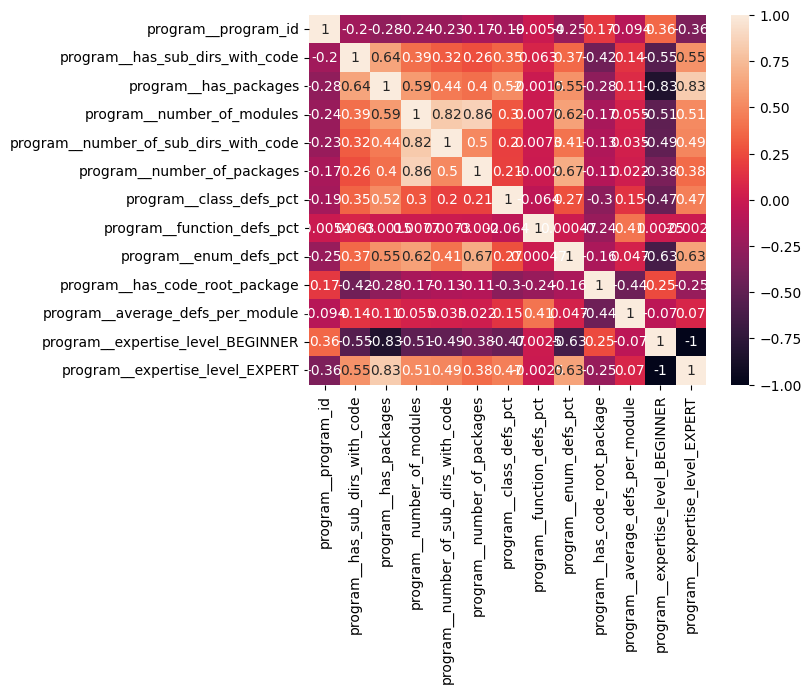

In [81]:
sns.heatmap(X.corr(), annot=True)

--> ABEL COMPLETAR <-- De la matriz anterior ya podemos sacar alguna conclusión que puede parecer obvia. Por ejemplo podemos secir que cuantas más interfaces tiene un programa menos clases va a tener. Y, lo mismo se aplica a las variables que representan si el código está en paquetes o no.

## 3 - Detección de valores atípicos (outliers)
Una vez sabemos qué datos contiene la tabla tenemos que explorar los valores que toma cada una de las variables de la tabla para cada instancia. El objetivo de hacer esto es identificar posibles valores atípicos que nos dificulten la realización de futuras tareas.

Para ello, lo primero que hacemos es explorar los valores que toman las variables de la tabla. Y, como se relacionan entre ellas. Y acontinuación las exploramos de forma individualizada.

## Univariate

Para cada uno de los atributos se debe realizar un análisis y detección de valores
atípicos, estudiando su posible causa. Tras su análisis, se puede concluir:

* **Su valor es erróneo.** En este caso hay que tomar una decisión para cada caso,
siendo los tratamientos más extendidos son listwise, pairwise, drop variables, mean/median
imputation, most frequent, separate category, zero imputation, cold deck, hot deck,
(stochastic) regression, k-NN and multiple imputation. Los resultados de imputación
regresiva, k-NN y múltiple dan buenos resultados, aunque, como se ha indicado, es
necesario el estudio en cada caso.

* **Es un valor anómalo, pero correcto.** Se documenta su existencia para su posible
discusión y se mantiene en el dataset. En estos casos se hace necesaria la utilización
de algoritmos y estadísticos que no sean muy sensibles a dichos valores anómalos.
Existen diversas formas de calcular los valores anómalos. Para las variables numéricas,
se suele identificar:
Valor atípico leve es el que está fuera de $[Q1 - 1.5IQR, Q3 + 1.5IQR]$, donde $IQR = Q3-Q1$.
Valor atípico extremo está fuera de $[Q1 - 3IQR, Q3 + 3IQR]$.

La idea es probar con a) y si hay pocas instancias analizarlas. Si hubiese muchas, mirar b)
y analizar si fuesen pocas. No hay un algoritmo o método estipulado, puesto que depende
del dominio del problema y de los datos.

Para las variables categóricas no existe el concepto de valor anómalo, pero sí se puede
considerar en base a un análisis de frecuencia. Por ejemplo, en Java el uso de strictfp es residual, pudiendo tener un 0.1% de instancias en el dataset. Para detectar estos
valores, se puede fijar un valor mínimo de frecuencia en función del número posible de
valores de la variable categórica (2 en el caso de una variable booleana). Por ejemplo, un umbral de $\frac{0.2\%}{valores}$ (0.1% en el caso de una variable booleana)

Entonces, para cada una de las tablas que componen nuestro dataset, realizaremos un análisis individual por cada una de las variables que contenga.

### Variable has_sub_dirs_with_code
Esta variable es de tipo booleano y representa si el programa contiene algún subdirectorio con código. El primer paso es hacer un análisis visual de como se distribuyen los valores de la variable.

<Axes: ylabel='program__has_sub_dirs_with_code'>

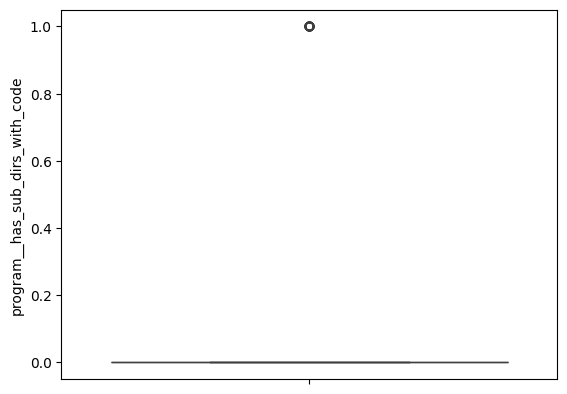

In [82]:
sns.boxplot(X['program__has_sub_dirs_with_code'])

Sabemos que la variable representa un valor boleano, 0 = false y 1 = verdadero. En la gráfica y a simple vista parece que tenemos muchas mas instancias de un tipo que del otro, lo cual podría ser extraño. Así que vamos a hacer un análisis numérico en detalle que nos ayude a descubrir qué está pasando.

In [86]:
num_true_values = len(X[X['program__has_sub_dirs_with_code'] == True])
num_false_values = len(X[X['program__has_sub_dirs_with_code'] == False])
std = X['program__has_sub_dirs_with_code'].std()
freq_true = len(X[X['program__has_sub_dirs_with_code'] == True]) / len(X['program__has_sub_dirs_with_code'])
freq_false = len(X[X['program__has_sub_dirs_with_code'] == False]) / len(X['program__has_sub_dirs_with_code'])
print(f'La variable has_sub_dirs_with_code contiene {num_true_values} valores verdaderos y {num_false_values} valores falsos. Y, la desviación típica es de {std}')
print(f'La frecuencia con la que programa puede tener la variable has_sub_dirs_with_code a True es {freq_true}.')
print(f'La frecuencia con la que programa puede tener la variable has_sub_dirs_with_code a False es {freq_false}.')

La variable has_sub_dirs_with_code contiene 51 valores verdaderos y 1558 valores falsos. Y, la desviación típica es de 0.17524586617946625
La frecuencia con la que programa puede tener la variable has_sub_dirs_with_code a True es 0.031696706028589185.
La frecuencia con la que programa puede tener la variable has_sub_dirs_with_code a False es 0.9683032939714108.


In [85]:
possible_values = [True, False]
print_frequency_anal_for_cat_var(X, 'program__has_sub_dirs_with_code', possible_values)

Variable program__has_sub_dirs_with_code contains 2 different values.
The outlier threshold is 0.1%
Variable program__has_sub_dirs_with_code takes on the value 0.0 in 96.83032939714109% of items.
Variable program__has_sub_dirs_with_code takes on the value 1.0 in 3.1696706028589183% of items.


Describimos los valores de las variables de la tabla, cuando la variable tiene el valor a True.

In [91]:
X[X['program__has_sub_dirs_with_code'] == True].describe(percentiles=[.25, .50, .75], include = ['object', 'float', 'bool', 'int'])

,program__program_id,program__has_sub_dirs_with_code,program__has_packages,program__number_of_modules,program__number_of_sub_dirs_with_code,program__number_of_packages,program__class_defs_pct,program__function_defs_pct,program__enum_defs_pct,program__has_code_root_package,program__average_defs_per_module,program__expertise_level_BEGINNER,program__expertise_level_EXPERT
count,51.000,51.0,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.0,51.000000,51.000000,51.000000
mean,5498022.500,1.0,0.431373,282.568634,12.431373,51.607841,0.164255,0.814500,0.001638,0.0,4.124859,0.666667,0.333333
std,2045936.125,0.0,0.500196,653.941162,37.047134,187.675156,0.195925,0.227913,0.004116,0.0,3.806759,0.476095,0.476095
min,1.000,1.0,0.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
25%,4236303.000,1.0,0.000000,3.000000,1.000000,0.000000,0.000000,0.633807,0.000000,0.0,1.000000,0.000000,0.000000
50%,5980490.000,1.0,0.000000,7.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.0,3.155406,1.000000,0.000000
75%,6454846.000,1.0,1.000000,392.500000,4.000000,44.000000,0.365667,1.000000,0.000000,0.0,5.775416,1.000000,1.000000
max,9332840.000,1.0,1.000000,3294.000000,238.000000,1297.000000,0.624539,1.000000,0.019078,0.0,17.000000,1.000000,1.000000


Esto nos confirma que tenemos casi todos los programas con esta variable a false. Una posible hipótesis es que --> ABEL COMPLETAR <--

### Variable has_packages
Esta variable es de tipo booleano y representa si el programa contiene algún paquete. El primer paso es hacer un análisis visual de como se distribuyen los valores de la variable.

--> ABEL COMPLETAR <-- Esta me la salto porque es igual que la anterior, seria hacer lo mismo que en la anterior.

### Variable number_of_modules
Esta variable es de tipo numérica y nos indica el número de modulos definidos en el programa.

<Axes: ylabel='program__number_of_modules'>

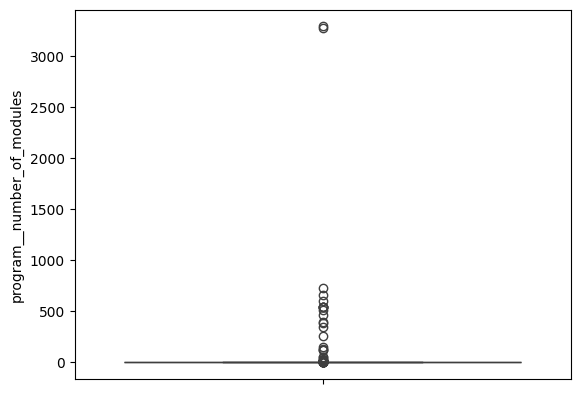

In [87]:
sns.boxplot(X['program__number_of_modules'])

In [88]:
print_outliers_for_df_column(X, 'program__number_of_modules')

The MC (Medcouple Coefficient) for balancing is: 0.9621331795279673
Strong range of outlier values (Tukey): [-5.0,9.0]
Weak range of outlier values (Tukey): [-2.0,6.0]
Strong range of outlier values (Fixed BoxPlot): [0.8965693397098071,143.772485167085]
-3.0IQR: 0 instances with a value for program__number_of_modules lower than -5.0 (Q1-3*IQR) for program__number_of_modules. Representing 0.0% of the total instances.
-1.5IQR: 0 instances with a value for program__number_of_modules lower than -2.0 (Q1-1.5*IQR) for program__number_of_modules. Representing 0.0% of the total instances.
+1.5IQR: 64 instances with a value for program__number_of_modules upper than 6.0 (Q3+1.5*IQR) for program__number_of_modules. Representing 3.9776258545680543% of the total instances.
+3.0IQR: 33 instances with a value for program__number_of_modules upper than 9.0 (Q3-3*IQR) for program__number_of_modules. Representing 2.050963331261653% of the total instances.
L: 0 instances with a value for program__number_o

Describimos los valores de las variables de la tabla, cuando el valor de la variable es mayor que 9 (Tukey rango extremo)

In [92]:
X[X['program__number_of_modules'] > 9.0].describe(percentiles=[.25, .50, .75], include = ['object', 'float', 'bool', 'int'])

,program__program_id,program__has_sub_dirs_with_code,program__has_packages,program__number_of_modules,program__number_of_sub_dirs_with_code,program__number_of_packages,program__class_defs_pct,program__function_defs_pct,program__enum_defs_pct,program__has_code_root_package,program__average_defs_per_module,program__expertise_level_BEGINNER,program__expertise_level_EXPERT
count,33.0,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000
mean,4809714.0,0.757576,0.696970,438.121216,18.363636,80.060608,0.261645,0.735824,0.002531,0.121212,4.421386,0.454545,0.545455
std,2160770.5,0.435194,0.466694,773.042969,45.189060,229.504227,0.190358,0.191416,0.004914,0.331434,3.108916,0.505650,0.505650
min,1.0,0.000000,0.000000,10.000000,0.000000,0.000000,0.000000,0.375461,0.000000,0.000000,0.733333,0.000000,0.000000
25%,3519145.0,1.000000,0.000000,22.000000,1.000000,0.000000,0.000000,0.617599,0.000000,0.000000,2.000000,0.000000,0.000000
50%,4554867.0,1.000000,1.000000,148.000000,3.000000,11.000000,0.316770,0.678571,0.000000,0.000000,4.451495,0.000000,1.000000
75%,6402106.0,1.000000,1.000000,541.000000,8.000000,73.000000,0.368945,1.000000,0.003165,0.000000,5.774492,1.000000,1.000000
max,8824678.0,1.000000,1.000000,3294.000000,238.000000,1297.000000,0.624539,1.000000,0.019078,1.000000,16.700001,1.000000,1.000000


## Multivariate

TODO: isolation forest algorithm

In [93]:
from sklearn.ensemble import  IsolationForest

CONTAMINATION_FACTOR = 0.0012

isof_model = IsolationForest(contamination=CONTAMINATION_FACTOR, random_state=0)
isof_prediction = isof_model.fit_predict(X.to_numpy())
mask = isof_prediction == -1
multivar_outliers = X[mask].index.tolist()
full_table.iloc[multivar_outliers]

,program__program_id,program__has_sub_dirs_with_code,program__has_packages,program__number_of_modules,program__number_of_sub_dirs_with_code,program__number_of_packages,program__class_defs_pct,program__function_defs_pct,program__enum_defs_pct,program__has_code_root_package,program__average_defs_per_module,program__expertise_level
2,560766,True,True,3278,238,380,0.248424,0.746025,0.005551,False,4.451495,EXPERT
3,2356327,True,True,3294,68,1297,0.368945,0.611977,0.019078,False,1.829994,EXPERT
